# Environment Setup

In [5]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [6]:
!pip install mplfinance

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from pandas_profiling import ProfileReport as profile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Introduction & Problem Statements

Within this notebook is an assessment of common bar sampling techniques that are used in the financial industry. Specifically, we aim to assess the statistical properties of time, tick, volume and dollar based bar sampling.


When one hears "good data", it instinctually invokes the idea of clealiness. However, good quality data, in the context of  financial modelling/inference (or any statistical modelling) ,is  along the lines of the "underlying statistical properties" of said data.

Recall that most statistical methods have within them,  embedded assumtions. Assumptions such as normality and independence of observation. It would therefore be errerneous to ignore these assumtions. Starting with time based bar sampling, we will progressively generate, then assess the tick, volume and dollar bars.


**Problem statement**

Due to their visually simplistic appeal, interval bars are the go-to for the assessment of market structure in a 'discretionary' way. That is, time based bars allow for discretionary assesment of historical asset price fluctuations. While this approach may provide a general understanding of historical price action and help the trader identify patterns or trends, it may overlook subtle nuances in market behavior that could impact the performance of quantitative models.

Unlike humans, however, machine learning models do not benefit much from the visually simplistic nature of interval bars. In simpler terms, **the model fails to capture important market dynamics **due to the inherent limitations of time-based bars in representing market structure accurately.

> When drawing inference from a random variable, it's important for that variable to be invariant, meaning it remains consistent and stable across different conditions or timeframes.  

Invariance ensures that the statistical properties of the random variable (price) remain stable over time. If the variable were to change significantly based on external factors or timeframes, it would be challenging to draw reliable conclusions from it.

*Note: Normalisation and standardization are common examples of techniques that are used to make variables invariant*

Incorporating invariant variables in financial models has been shown to significantly enhance their robustness and predictive accuracy. To address this challenge, researchers are exploring alternative approaches to time-based bar sampling, such as volume-based bars or tick bars, which are invariant to time intervals and better capture market dynamics.




# Data Retrival, Exploration & Pre-processing

In [8]:
df = pd.read_csv("/content/drive/MyDrive/Advances In Financial Machine Learning /BTCUSDT-trades-2021-02-01.csv")
#Uncomment to control slicing - use n records for analysis
#n = 1500000
#df = df.head(n)

In [9]:
#Variable renaming
old = ['459310582', '33125.11', '0.01', '331.25', '1612137600867', 'true']
new = ['code', 'price', 'qty', 'base_qty', 'timestamp', 'is_buyer_maker']

for i in zip(old,new):
  print(i)

df = df.rename(columns=dict(zip(old,new)))


('459310582', 'code')
('33125.11', 'price')
('0.01', 'qty')
('331.25', 'base_qty')
('1612137600867', 'timestamp')
('true', 'is_buyer_maker')


# Exploration

In [10]:
df.head()

code     price    qty  base_qty      timestamp  is_buyer_maker
0  459310583  33125.11  0.010    331.25  1612137600870            True
1  459310584  33124.00  0.050   1656.20  1612137600870            True
2  459310585  33124.01  0.011    364.36  1612137600873           False
3  459310586  33124.00  0.001     33.12  1612137600877            True
4  459310587  33124.01  0.020    662.48  1612137600878           False

In [11]:
df.describe()

code         price           qty      base_qty     timestamp
count  2.421172e+06  2.421172e+06  2.421172e+06  2.421172e+06  2.421172e+06
mean   4.605212e+08  3.374564e+04  9.938671e-02  3.354315e+03  1.612176e+12
std    6.989633e+05  4.507567e+02  4.440730e-01  1.500556e+04  2.347553e+07
min    4.593106e+08  3.232247e+04  1.000000e-03  3.232000e+01  1.612138e+12
25%    4.599159e+08  3.356000e+04  7.000000e-03  2.382600e+02  1.612159e+12
50%    4.605212e+08  3.375558e+04  2.700000e-02  9.038600e+02  1.612174e+12
75%    4.611265e+08  3.397514e+04  8.000000e-02  2.724222e+03  1.612195e+12
max    4.617318e+08  3.472000e+04  7.812100e+01  2.615721e+06  1.612224e+12

In [12]:
df.shape

(2421172, 6)

In [13]:
report  = profile(df)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert milliseconds to datetime format


In [15]:
df.shape

(2421172, 6)

# Time Bars

Time-based/interval bars, are a method used in financial market analysis to collect/aggregate and summarize trading activity over fixed time intervals. To generate time based bars, we would aggregate the data based on a fixed, arbitrary time interval. That is, regardless of the number of trades  that take place, a bar is only sampled when the interval threshold is reached. Using time bars, the trading days are divided into fixed time intervals e.g 1 minute, 5 minutes, 1 hour, or 1 day, with the 5 minute  being among the most popular among "retail traders".


Within each time interval, trading activity is aggregated and summarized. This aggregation typically includes open, high, low, and close prices for the interval, as well as volume traded during that time period. Because of their 'human-friendly' nature, time-based bars are often used to visualize and analyze price movements, identify trends, and spot patterns in the market. Traders and analysts use these bars to make trading decisions, assess market volatility, and develop trading strategies. Conventionally, when a candle closes (based on the interval) at a higher price than its open price, we color it green. If the opposite happes, a red color is given to the candle.


In [16]:
def generate_time_bars(tick_data, time_interval):
    '''
    This function is used to aggregate tick data based on the time threshold 'time_interval'

    '''
    # Convert 'timestamp' column to datetime if it's not already
    tick_data['timestamp'] = pd.to_datetime(tick_data['timestamp'], unit = 'ms')

    # Resample tick data into time bars: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    time_bars = tick_data.set_index('timestamp').resample(time_interval).agg({
        'price': 'ohlc',
        'qty': 'sum',
        'base_qty': 'sum'
    })

    # Flatten multi-level columns - returns columns of columns eg a price column containing the generated colmns (open, high low, close), nested(
    time_bars.columns = [f'{c[1]}' for c in time_bars.columns]

    return time_bars

# func callc
time_bars_df = generate_time_bars(df, time_interval='1min')


In [17]:
#Calculate the number of bars that can be generated using the exisiting tick data
total_duration_ms = df['timestamp'].max() - df['timestamp'].min()
total_duration_minutes = total_duration_ms / (1000 * 60)  # Convert milliseconds to minutes
num_5min_intervals = total_duration_minutes / 5
print(num_5min_intervals)


0 days 00:00:00.287997093


Since time bars are only sampled at the set/arbitrary time intervals, it doesn't matter how much value has been exchanged, the open price will be the first price in the interval, the high will be the max price in the bar etc.

Meaning that if there's low trading avtivity in the market, bars are still formed, thus oversampling. That is, regardless of how much trading activity is in the market, time bars only sample the OHLC at the set threshold; since the sampling is restricted by time, we loose a lot of informattion and are thus unable to capture any 'new information' from changes in trading/market activity.


"New information" in this context refers to new market information. That is, any fresh data, news, announcements, reports, or other relevant developments that have the potential to influence the behaviour of market participants, and thus, the valuation of said asset. Trading activity is more of a "leading indicator" in that regard.


This concept of "new information" is especially relevant in the modern information driven world, whether  the new information is being leveraged by insiders or "smart money", this presents an opportunity for the diligent investor.

# Tick Bars

As opposed to time based bars, tick bars are formed based on frequency of trades/ticks and not time. In other words, we set an arbitrary number of trades as the threshold to determine bar sampling. For example, forming candlesticks every 1000 trades.

In [18]:
import pandas as pd

def generate_tick_bars(df, tick_threshold):
    '''
    Generate tick bars based on the tick threshold.

    Parameters:
        df (DataFrame): DataFrame containing tick data with columns ['timestamp', 'price'].
        tick_threshold (int): Number of ticks required to sample a tick bar.

    Returns:
        tick_bars_df (DataFrame): DataFrame containing tick bars with columns ['timestamp', 'open', 'high', 'low', 'close', 'volume'].
    '''
    tick_bars = []
    tick_counter = 0
    start_index = 0
    tick_counter = 0
    volume = 0

    for i in range(len(df)):
        tick_counter += 1
        volume += 1

        if tick_counter >= tick_threshold:
            tick_bar = {
                'timestamp': df['timestamp'].iloc[i],
                'open': df['price'].iloc[start_index],
                'high': df['price'].iloc[start_index:i+1].max(),
                'low': df['price'].iloc[start_index:i+1].min(),
                'close': df['price'].iloc[i],
                'volume': volume
            }
            tick_bars.append(tick_bar)
            tick_counter = 0
            start_index = i + 1
            volume = 0

    return pd.DataFrame(tick_bars)


Tick bars are useful for capturing changes in market activity and volatility, as they adjust dynamically based on trading activity. That is, if for some reason there is a lot of activity in the markets (buying or selling) tick bars will be formed in direct proportion. For demonstration purposes, we use an arbitrary yet popular threshold of 100 ticks.

NOTE: In practice, a more dynamic/accurate approach would be to somehow use existing data to set the threshold.

In [19]:
tick_bars_df = generate_tick_bars(df=df, tick_threshold= 100)

In [20]:
tick_bars_df.shape

(24211, 6)

# Volume Bars

Although there may be a notable connection between the number of trades placed and the arrival of new information, this correlation isn't assured. For instance, a sophisticated algorithm or trader might strategically place numerous small, repetitive orders to manipulate market sentiment (making the trade history appear favorable), concealing the total volume (referred to as iceberg orders), or confuse other trading algorithms by distorting the timing of information arrival. Volume bars are based on the volume (quantity) of assets traded.

Instead of counting the number of trades, volume bars aggregate data based on the cumulative volume/quantity of assets exchanged. Each time the cumulative volume reaches a certain threshold, a new volume bar is formed. Volume bars are useful for capturing changes in trading volume and liquidity in the market.

In [21]:

def gen_volumebars_df(trades_df, frequency):
    times = trades_df['timestamp'].values
    prices = trades_df['price'].values
    volumes = trades_df['qty'].values
    ans = []
    candle_counter = 0
    vol = 0
    lasti = 0
    for i in range(len(prices)):
        vol += volumes[i]
        #If the total volume is greater than or equal to the set threshold, Sample bars
        if vol >= frequency:
            candle = {
                'timestamp': times[i],                   # time
                'open': prices[lasti],                   # open
                'high': np.max(prices[lasti:i+1]),       # high
                'low': np.min(prices[lasti:i+1]),        # low
                'close': prices[i],                      # close
                'volume': np.sum(volumes[lasti:i+1])     # volume
            }
            ans.append(candle)
            candle_counter += 1
            lasti = i+1
            vol = 0
    return pd.DataFrame(ans)

NOTE: The volume threshold below was set using the median volume in the dataset

In [22]:
vol_bars = gen_volumebars_df(trades_df= df, frequency = 2.700000e-02)

In [23]:
vol_bars.shape

(1395428, 6)

The issue with volume bars is that the volume of trades conducted may be strongly linked to the actual worth of the asset being traded. For example, with USD10,000, you could purchase approximately 10 bitcoins in early 2017, but by the end of 2017, that same amount could only buy half a bitcoin.

This significant fluctuation in the underlying value greatly diminishes the effectiveness of volume bars because a volume size that is significant at one point in time may not be significant in the near future due to changes in the asset's valuation.

One way to address this fluctuation is by shifting from counting the number of assets traded (volume bars) to counting the quantity of fiat currency exchanged (dollar bars).
Consider a scenario where an investor trades stocks of two different companies, Company A and Company B. Both companies have different stock prices, with Company A's stock priced at $100 per share and Company B's stock priced at USD50 per share.

Initially, the investor purchases USD10,000 worth of Company A's stock, acquiring 100 shares.
Subsequently, the investor decides to invest the same amount, 10,000 USD, in Company B's stock. However, due to the lower price per share, this 10,000USD investment now buys 200 shares of Company B.

In this example, even though the investor traded the same dollar amount (10,000 USD) in both instances, the number of shares acquired differs significantly between the two companies due to their different stock prices. This discrepancy highlights how volume bars, which solely consider the number of shares traded, may not accurately capture the investor's trading activity or market dynamics.

# Dollar Bars


Dollar bars are sampled based on the total value (price x quantity) of transactions, rather than the number of assets traded. That is, Dollar bars are generated by aggregating trading activity until a specified dollar value threshold is reached. For example, a trader may set the threshold at 1,000USD, meaning that a new dollar bar is created whenever the total value of transactions reaches or exceeds USD1,000.

In [24]:

def gen_dollarbars(trades_df, frequency):
    times = trades_df['timestamp'].values
    prices = trades_df['price'].values
    volumes = trades_df['qty'].values
    ans = []
    candle_counter = 0
    dollars = 0
    lasti = 0
    for i in range(len(prices)):
        dollars += volumes[i]*prices[i]
        if dollars >= frequency:
            candle = {
                'timestamp': times[i],                   # time
                'open': prices[lasti],                   # open
                'high': np.max(prices[lasti:i+1]),       # high
                'low': np.min(prices[lasti:i+1]),        # low
                'close': prices[i],                      # close
                'volume': np.sum(volumes[lasti:i+1])     # volume
            }
            ans.append(candle)
            candle_counter += 1
            lasti = i+1
            dollars = 0
    return pd.DataFrame(ans)

Nottice how similar the process is to that of the volume bars. If you did't, the main differencence is in
```
dollars += volumes[i]*prices[i]
if dollars >= frequency:
```

In [25]:

dollar_bars = gen_dollarbars( df,2.700000e-02)

In [26]:
print(dollar_bars.shape)
#print(dollar_bars2.shape)

(2421172, 6)


# Visualization/Comparison

In [27]:
time_bars_df.shape

(1440, 6)

Plotting the generated close price data, we can see how,using the same dataset, the generated time, tick, volume and dollar bars compare;

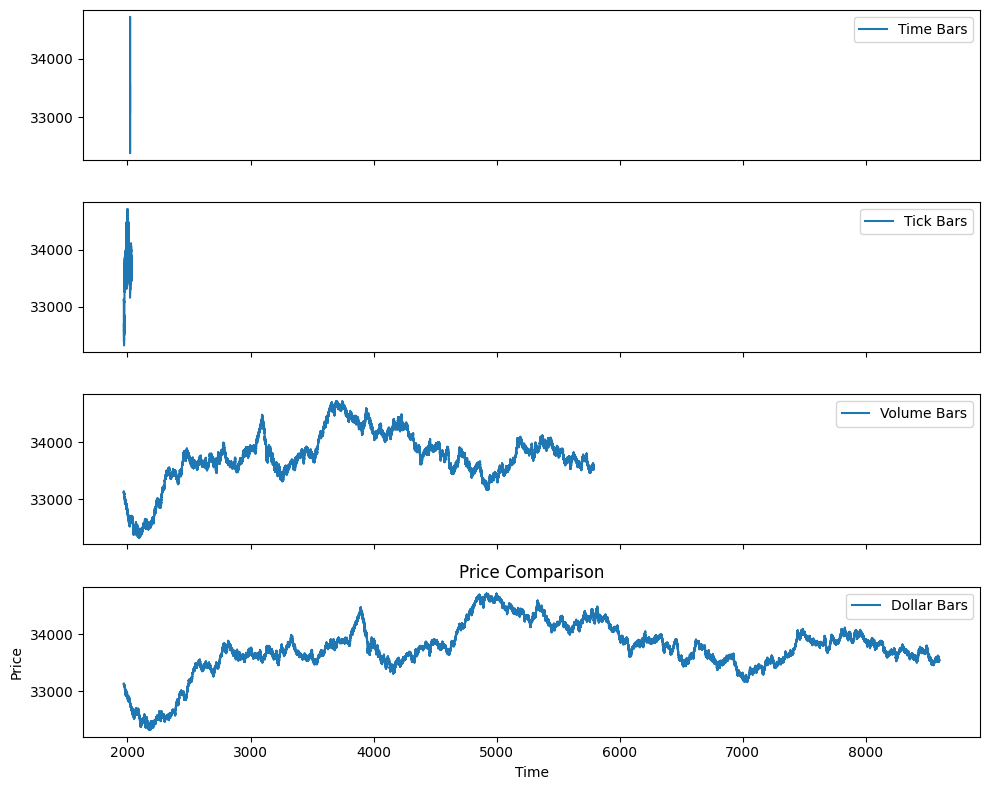

In [28]:
time_price = time_bars_df['close']

tick_price = tick_bars_df['close']

vol_price = vol_bars['close']
dollar_price = dollar_bars['close']

# Create subplots with 4 axes (one for each price column)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

# Plot each price column on a separate axis
axes[0].plot(time_price, label='Time Bars')
axes[1].plot(tick_price, label='Tick Bars')
axes[2].plot(vol_price, label='Volume Bars')
axes[3].plot(dollar_price, label='Dollar Bars')

# Add labels and title to the last subplot
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Price')
axes[3].set_title('Price Comparison')

# Add legend to each subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


Though hardly visible, a total of 1440 bars were generated using time based bar sampling.Recall that the tick data used herein had 2million+ records. This goes to show just how inefficient time based sampling. Also note that the sampling timeframe(window) was used simply for demonstration purposes as the more popular 5 minute time frame proved to be even more inefficient; 288 bars. Inefficient in this context refers to intraday sampling.Plotting the samples seperately, as OHLC gives a more accurate depiction of the data;

In [47]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

# Create a function to generate OHLC plots for a given price column
def generate_ohlc_plot(df, title):
    if not df.empty:
        fig = go.Figure(data=[go.Candlestick(x=df.index,
                                              open=df['open'],
                                              high=df['high'],
                                              low=df['low'],
                                              close=df['close'],
                                              name=title)])
        fig.update_xaxes(title_text='Time')
        fig.update_yaxes(title_text='Price')
        fig.update_layout(title=title, showlegend=True)
        fig.show()

NOTE: For comparison, we only plot 1440 records of each, with the goal of matching the number time bars generated

In [48]:
# Generate separate OHLC plots for each price column
generate_ohlc_plot(time_bars_df, 'Time Bars')


In [31]:
generate_ohlc_plot(tick_bars_df[:1440], 'Tick Bars')


In [32]:
generate_ohlc_plot(vol_bars[:1440], 'Volume Bars')


In [33]:
generate_ohlc_plot(dollar_bars[:1440], 'Dollar Bars')

# Autocorrelation Tests

In [34]:
#Slice to match the number of time bars
#tick_bars_df = tick_bars_df.head(len(time_bars_df))
#vol_bars = vol_bars.head(len(time_bars_df))
#dollar_bars = dollar_bars.head(len(vol_bars))


In [35]:

# Extract the closing prices from the time bars DataFrame
closing_prices_time = time_bars_df['close']
# Calculate the autocorrelation of the closing prices with a lagged version (shifted by 1)
autocorr_time = closing_prices_time.autocorr(lag=1)


In [36]:

# Extract the closing prices from the tick bars DataFrame
closing_prices_tick = tick_bars_df['close']
# Calculate the autocorrelation of the closing prices with a lagged version (shifted by 1)
autocorr_tick = closing_prices_tick.autocorr(lag=1)


In [37]:
# Extract the closing prices from the volume bars DataFrame
closing_prices_vol = vol_bars['close']
# Calculate the autocorrelation of the closing prices with a lagged version (shifted by 1)
autocorr_vol= closing_prices_vol.autocorr(lag=1)


In [38]:
# Extract the closing prices from the dollar bars DataFrame
closing_prices_dollar = dollar_bars['close']
# Calculate the autocorrelation of the closing prices with a lagged version (shifted by 1)
autocorr_dollar= closing_prices_dollar.autocorr(lag=1)

In [39]:
print(f'TIME {closing_prices_time.shape}')
print(f'TICK {closing_prices_tick.shape}')
print(f'VOL {closing_prices_vol.shape}')
print(f'DOLLAR {closing_prices_dollar.shape}')
#print(f'vol2 {closing_prices_vol2.shape}')

TIME (1440,)
TICK (24211,)
VOL (1395428,)
DOLLAR (2421172,)


In [40]:
print(f'TIME {autocorr_time}')
print(f'TICK {autocorr_tick}')
print(f'VOL {autocorr_vol}')
print(f'DOLLAR {autocorr_dollar}')
#print(f'Vol2 {autocorr_vol2}')

TIME 0.9927409405281571
TICK 0.999688669897356
VOL 0.9999937341801475
DOLLAR 0.9999958655386668


The above correlation coeffiecients do not account for the difference in sample sizes, and thus, are misleading. To address this, we normalize each coeffiecient using the respective sample size;

> normalised = coefficient / n



In [41]:
import math
autocorr_time_n = (autocorr_time/math.sqrt(len(closing_prices_time)))
autocorr_tick_n = autocorr_tick/math.sqrt(len(closing_prices_tick))
autocorr_vol_n = autocorr_vol/math.sqrt(len(closing_prices_vol))
autocorr_dollar_n = autocorr_dollar/math.sqrt(len(closing_prices_dollar))

print (autocorr_time_n)
print (autocorr_tick_n)
print (autocorr_vol_n)
print (autocorr_dollar_n)

0.026161020821389474
0.006424782147765103
0.0008465323559164969
0.0006426660868417153


A Pearson autocorrelation close to 1 suggests high persistence in the variables. The results indicate that the values of TICK, VOL, and DOLLAR are highly correlated with their previous values, indicating a strong tendency for the variables to maintain their direction or trend over time.

Nottice, however, how the normalised autocorrelation reduces gradually as we progress from tick to dollar bars. This doesn't in any way imply that volume and dollar bars are the most superior, instead, it goes to show the improvement in statistical properties, which is further demonstrated below. In reality, more rigorous testing would be require (for example using grid-searching techniques)

# Normality Tests

**Shapiro-Wilk**

The Shapiro-Wilk test is a statistical test used to assess whether a given sample of data follows a normal distribution. It tests the null hypothesis that the data are drawn from a normal distribution against the alternative hypothesis that the data are not normally distributed.

The test statistic calculated by the Shapiro-Wilk test. It measures the discrepancy between the observed data and what would be expected under the assumption of normality. The closer the test statistic is to 1, the more closely the data resemble a normal distribution.



In [42]:
from scipy.stats import shapiro
#~Time

# Perform the Shapiro-Wilk test for normality
statistic, p_value = shapiro(closing_prices_time)

# Set significance level (alpha)x
alpha = 0.05

# Print the results
print("Shapiro-Wilk Test:")
print("Test Statistic:", round(statistic, 3))
print("p-value:", p_value)

# Check the p-value against the significance level
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test:
Test Statistic: 0.911
p-value: 2.910555128441648e-28
The data does not appear to be normally distributed (reject H0)


In [43]:
from scipy.stats import shapiro

#~Ticks
# Perform the Shapiro-Wilk test for normality
statistic, p_value = shapiro(closing_prices_tick)

# Set significance level (alpha)
alpha = 0.05

# Print the results
print("Shapiro-Wilk Test:")
print("Test Statistic:", round(statistic,3))
print("p-value:", p_value)

# Check the p-value against the significance level
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test:
Test Statistic: 0.939
p-value: 0.0
The data does not appear to be normally distributed (reject H0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



In [44]:
#~Volume
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
statistic, p_value = shapiro(closing_prices_vol)

# Set significance level (alpha)
alpha = 0.05

# Print the results
print("Shapiro-Wilk Test:")
print("Test Statistic:", round(statistic, 3))
print("p-value:", p_value)

# Check the p-value against the significance level
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test:
Test Statistic: 0.943
p-value: 0.0
The data does not appear to be normally distributed (reject H0)


In [45]:
#~Dollar
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
statistic, p_value = shapiro(closing_prices_dollar)

# Set significance level (alpha)
alpha = 0.05

# Print the results
print("Shapiro-Wilk Test:")
print("Test Statistic:", round(statistic, 3))
print("p-value:", p_value)

# Check the p-value against the significance level
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test:
Test Statistic: 0.939
p-value: 0.0
The data does not appear to be normally distributed (reject H0)


Observe how, like with the autocorrelation tests, we see a gradual increase in the test statistic as we progress from time to dollar bars. We thus conclude, based on the generated results, that tick, volume and dollar bars are a lot more efficient and statistically potent.